# Group 11 Re-Ranking

## Library Installations

In [1]:
!apt-get install -y libleveldb-de
!pip install plyvel
!pip install mplfinance
!pip install mplcursors
!pip install datasets
!pip install rank_bm25
!pip install transformers
!pip install hnswlib
!pip install nltk

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libleveldb-de
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.8/877.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source o

## Data Insertion in LevelDB

In [2]:
from datasets import load_dataset
import plyvel
import os

db_path = '/content/msmarco_db'

lock_file_path = os.path.join(db_path, 'LOCK')
if os.path.exists(lock_file_path):
    os.remove(lock_file_path)

ds = load_dataset("microsoft/ms_marco", "v1.1", split='test')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10047 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/82326 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9650 [00:00<?, ? examples/s]

In [3]:
import pandas as pd
df = pd.DataFrame(ds.take(5))
print(df.head())

                                             answers  \
0                                              [Yes]   
1  [Fossil fuels are basically the remains of ani...   
2  [The apothem of a regular polygon is a line se...   
3                                   [$45 to $210. 2]   
4  [It is the collection of physical elements tha...   

                                            passages  \
0  {'is_selected': [0, 0, 1, 0, 0, 0, 0], 'passag...   
1  {'is_selected': [0, 1, 0, 0, 0, 0, 0, 0, 0], '...   
2  {'is_selected': [0, 0, 0, 0, 0, 1, 0, 0, 0], '...   
3  {'is_selected': [0, 0, 0, 0, 0, 1, 0, 0, 0], '...   
4  {'is_selected': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]...   

                                   query  query_id   query_type  \
0         does human hair stop squirrels         0  description   
1  what are the benefits of fossil fuels         1  description   
2                      what is a apothem         2  description   
3         average cost for custom canopy         3      nu

In [4]:
import json
import plyvel

db = plyvel.DB(db_path, create_if_missing=True)

for example in ds:
    data = {}
    for key, value in example.items():
            data[key] = value
    db.put(
        str(example['query_id']).encode('utf-8'),
        json.dumps(data).encode('utf-8')
    )

db.close()


In [5]:
db = plyvel.DB(db_path, create_if_missing=False)
row_count = sum(1 for _ in db)
db.close()
print(f"Number of rows in the database: {row_count}")

Number of rows in the database: 9650


## Data retrival from LevelDB

In [6]:
db = plyvel.DB(db_path, create_if_missing=False)

query_ids = []
answers = []
passages = []
queries = []
query_types = []
wellFormedAnswers = []

# Retrieve data from the database
for key, value in db:
    data = eval(value.decode('utf-8'))  # Convert string back to dictionary
    query_ids.append(data['query_id'])
    answers.append(data['answers'])
    passages.append(data['passages'])
    queries.append(data['query'])
    query_types.append(data['query_type'])
    wellFormedAnswers.append(data['wellFormedAnswers'])

db.close()

data = {
    'query_id': query_ids,
    'query': queries,
    'query_type': query_types,
    'answers': answers,
    'passages': passages,
    'wellFormedAnswers': wellFormedAnswers
}
df = pd.DataFrame(data)

# print(df)


# TFIDF


## Turning the passages to lowercase

In [7]:
for i in range(len(df)):
    df['passages'][i]['passage_text'] = [item.lower() if isinstance(item, str) else item for item in df['passages'][i]['passage_text']]

## Remove Punctuation from the passages

In [8]:
import string

remove_punctuation_map = str.maketrans('', '', string.punctuation)

for i in range(len(df)):
    if isinstance(df['passages'][i]['passage_text'], list):

        df['passages'][i]['passage_text'] = [
            text.translate(remove_punctuation_map) if isinstance(text, str) else text
            for text in df['passages'][i]['passage_text']
        ]
    else:
        print(f"Row {i} has non-list data: {df['passages'][i]['passage_text']}")


## Tokenizing the data
eg: I am going out -> [‘I’ , ‘am’ , ‘going’]

In [9]:
for i in range(len(df)):
    if isinstance(df['passages'][i]['passage_text'], list):
        df['passages'][i]['passage_text'] = [
            word for text in df['passages'][i]['passage_text'] if isinstance(text, str) for word in text.split()
        ]
    else:
        print(f"Row {i} has non-list data: {df['passages'][i]['passage_text']}")


## Removing Stopwords from data

Words (such as “the”, “a”, “an”, or “in”) are removed as they act as noise to the data

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
from nltk.corpus import stopwords

for i in range(0,len(df)):
    txt = df['passages'][i]['passage_text']
    df['passages'][i]['passage_text'] = [w for w in txt if not w in stopwords.words('english')]

## Stemming

get the root word. eg: 'likes', 'liked', 'likely', 'liking' are converted to root word 'like'

In [14]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
stemmed = {}
for i in range(0,len(df)):
    l=[]
    for j in df['passages'][i]['passage_text']:
        l.append(stemmer.stem(j))
    stemmed[i]=l

## Calculating the TFIDF score for all the words present in the passages

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

passage_texts = [
    " ".join(stemmed[i])
    for i in range(len(df))
    if isinstance(stemmed[i], list)
]

vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(passage_texts)

words = vectorizer.get_feature_names_out()




Storing the tfidf score in dictionary in form of {'word1' : score1,    'word2' : score2,    'word3' : score3 .... }

In [16]:
tfidf_scores_dict = {}

# Iterate over each passage to get the TF-IDF scores
for doc_index, passage in enumerate(passage_texts):
    tfidf_vector = tfidf_matrix[doc_index]
    tfidf_scores = {
        words[word_index]: tfidf_vector[0, word_index]
        for word_index in tfidf_vector.indices
    }
    tfidf_scores_dict[f"doc_{doc_index}"] = tfidf_scores

## Creating the same preprocessing function for the user queries
(for testing purpose we just took one query)

In [21]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [22]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer


stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

query = "was ronald reagan a democrat"

# Preprocessing the query
def preprocess_query(query):
    query = query.lower()
    query = query.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(query)
    filtered_tokens = [word for word in tokens if word not in stop_words]

    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    return " ".join(stemmed_tokens)

# Preprocess the example query
preprocessed_query = preprocess_query(query)
print(f"Preprocessed query: {preprocessed_query}")


Preprocessed query: ronald reagan democrat


In [23]:
print(f"Preprocessed query: {preprocessed_query}")

Preprocessed query: ronald reagan democrat


In [24]:
query_vector = vectorizer.transform([preprocessed_query])

In [25]:
print(query_vector)

  (0, 33766)	0.4680568547181346
  (0, 76807)	0.6213439556432294
  (0, 78983)	0.6283744660128955


### Using Cosine similarity method to find top 3 (k=3) passages for getting answers to the queries

Cosine similarity is a mathematical measure used to evaluate the similarity between two vectors, often in high-dimensional spaces.

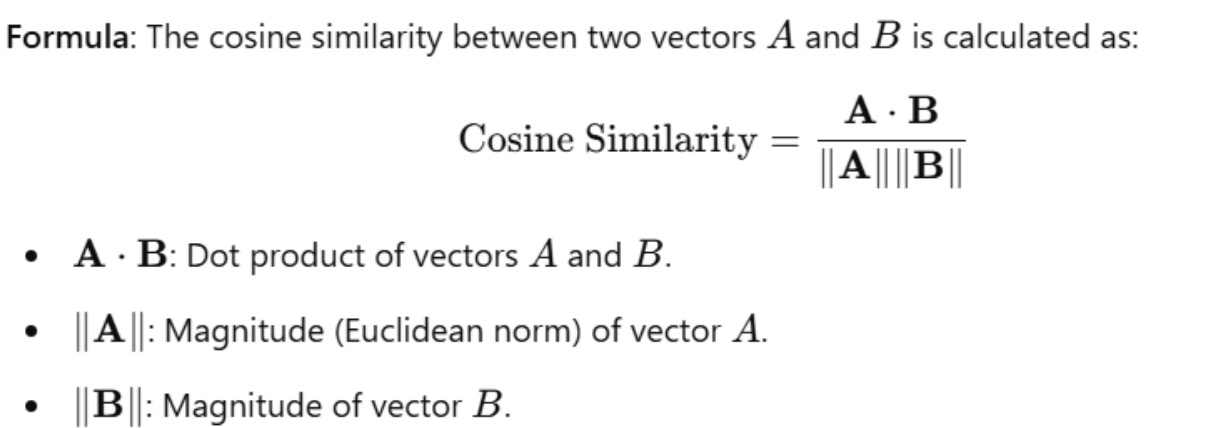

After top 3 we are showing answer from that passage which got the highest consine similarity score

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

query = "what is a apothem"
#query = "what kind of organism is a black damsel"
preprocessed_query = preprocess_query(query)

query_vector = vectorizer.transform([preprocessed_query])

# Compute cosine similarity between the query vector and passage TF-IDF matrix
similarity_scores = cosine_similarity(query_vector, tfidf_matrix).flatten()

ranked_indices = similarity_scores.argsort()[::-1]

top_k = 3
top_indices = ranked_indices[:top_k]

print(f"Top {top_k} passages:")
for idx in top_indices:
    passage = stemmed[idx]
    answer = df['answers'][idx]
    score = similarity_scores[idx]
    #print(f"Passage: {passage}\nAnswer: {answer}\nScore: {score}\n")

most_relevant_idx = top_indices[0]
best_passage = stemmed[most_relevant_idx]
best_answer = df['passages'][most_relevant_idx].get('answer', 'No answer available')
print("-------------------------")

print(most_relevant_idx)
print(f"Most relevant passage:\n{best_passage}\nAnswer: {df['answers'][most_relevant_idx]}")


Top 3 passages:
-------------------------
1112
Most relevant passage:
['apothem', 'apothem', 'regular', 'polygon', 'segment', 'drawn', 'center', 'polygon', 'center', 'circl', 'circumscrib', 'polygon', 'one', 'side', 'perpendicular', 'side', 'regular', 'polygon', 'area', 'squar', 'unit', 'perimet', 'p', 'unit', 'apothem', 'unit', 'area', 'onehalf', 'product', 'perimet', 'apothem', 'care', 'formula', 'though', 'given', 'apothem', 'one', 'possibl', 'valu', 'p', 'apothem', 'apothem', 'regular', 'polygon', 'distanc', 'center', 'midpoint', 'one', 'side', 'apothem', 'squar', 'equal', 'half', 'length', 'one', 'side', 'apothem', 'regular', 'polygon', 'definit', 'line', 'segment', 'center', 'regular', 'polygon', 'midpoint', 'side', 'tri', 'adjust', 'polygon', 'drag', 'orang', 'dot', 'alter', 'number', 'side', 'note', 'behavior', 'apothem', 'line', 'shown', 'blue', 'word', 'apothem', 'refer', 'line', 'length', 'line', 'correctli', 'say', 'draw', 'apothem', 'apothem', '4cm', 'formula', 'show', 'fi

## Caculating the accuracy for all the queries

accuracy = 80.83%

In [27]:
final_score=0
for i in range(0,len(df)):
    query=df['query'][i]
    query_id=df['query_id'][i]
    preprocessed_query = preprocess_query(query)  # Use your preprocessing function

    query_vector = vectorizer.transform([preprocessed_query])

    similarity_scores = cosine_similarity(query_vector, tfidf_matrix).flatten()

    ranked_indices = similarity_scores.argsort()[::-1]

    top_k = 3
    top_indices = ranked_indices[:top_k]
    for idx in top_indices:
        passage = stemmed[idx]
        answer = df['answers'][idx]
        score = similarity_scores[idx]


    most_relevant_idx = top_indices[0]
    best_passage = stemmed[idx]
    best_answer = df['passages'][most_relevant_idx].get('answer', 'No answer available')
    if df['query_id'][most_relevant_idx]==query_id:
        final_score=final_score+1
print(final_score/len(df))

0.8083937823834196


## Major Insight

There were few predicted answers which were not the same to actual answers but have same meaning so we are also finding the similarity score between predicted answers and actual answers. After that we are finding the final accuracy

In [28]:
final_score = 0

for i in range(len(df)):
    query = df['query'][i]
    query_id = df['query_id'][i]

    # Preprocess the query
    preprocessed_query = preprocess_query(query)

    query_vector = vectorizer.transform([preprocessed_query])

    similarity_scores = cosine_similarity(query_vector, tfidf_matrix).flatten()

    ranked_indices = similarity_scores.argsort()[::-1]

    top_k = 3
    top_indices = ranked_indices[:top_k]

    most_relevant_idx = top_indices[0]
    best_answer = df['passages'][most_relevant_idx].get('answer', 'No answer available')

    actual_answers = df['answers'][i]
    if isinstance(actual_answers, list):
        actual_answer = " ".join(actual_answers)
    else:
        actual_answer = str(actual_answers)

    # Preprocess both the actual and best answers
    preprocessed_actual_answer = preprocess_query(actual_answer)
    preprocessed_best_answer = preprocess_query(best_answer)

    answer_vectors = vectorizer.transform([preprocessed_actual_answer, preprocessed_best_answer])
    similarity = cosine_similarity(answer_vectors[0:1], answer_vectors[1:2]).flatten()[0]

    if df['query_id'][most_relevant_idx] == query_id or similarity >= 0.1:
        final_score += 1

accuracy = final_score / len(df)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 80.89%


# BERT

## Library Installations

In [ ]:
!pip install keras
!pip install transformers
!pip install sentence_transformers
!pip install tf_keras
!pip install datasets


## Model

In [ ]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset

# Load a general-purpose pre-trained model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
# ds = load_dataset("microsoft/ms_marco", "v1.1")
# df = pd.DataFrame(ds['test'])

print("Flattening passages...")
passage_texts = [
    " ".join(passage['passage_text']) if isinstance(passage['passage_text'], list) else passage['passage_text']
    for passage in tqdm(df['passages'], desc="Processing passages")
] 

Flattening passages...


Processing passages: 100%|██████████| 9650/9650 [00:00<00:00, 191492.64it/s]


In [ ]:
print("Generating embeddings for passages...")
passage_embeddings = model.encode(passage_texts, batch_size=128, show_progress_bar=True)



Generating embeddings for passages...


Batches:   0%|          | 0/76 [00:00<?, ?it/s]

In [ ]:
# Example query
query = "what is a apothem"

# Generate embedding for query
query_embedding = model.encode(query)

similarity_scores = util.cos_sim(query_embedding, passage_embeddings).flatten()
top_k = 5
ranked_indices = similarity_scores.argsort(descending=True)[:top_k]

print(f"\nTop {top_k} passages:")
for idx in ranked_indices:
    passage = passage_texts[idx]
    score = similarity_scores[idx].item()
    print(f"Passage: {passage}\nScore: {score}\n")


Top 5 passages:
Passage: Apothem. The apothem of a regular polygon is a segment drawn the center of the polygon (that is, the center of the circle which circumscribes the polygon) to one side, such that it is perpendicular to the side. If a regular polygon has an area of A square units, a perimeter of P units, an apothem of a units, then the area is one-half the product of the perimeter and the apothem. Be careful with this formula, though: for a given apothem, there is only ONE POSSIBLE value of P. Apothems. The apothem of a regular polygon is the distance from the center to the midpoint of one of its sides. The apothem of a square is equal to half of the length of one side.  Apothem of a Regular Polygon. Definition: A line segment from the center of a regular polygon to the midpoint of a side. Try this Adjust the polygon below by dragging any orange dot, or alter the number of sides. Note the behavior of the apothem line shown in blue. The word apothem can refer to the line itself, 

In [ ]:
def preprocess_query(query):
    return query.lower()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

answers = df['answers'].tolist()

preprocessed_query = preprocess_query(query)

query_vector = model.encode(preprocessed_query)

# Compute cosine similarity between the query embedding and passage embeddings
similarity_scores = cosine_similarity([query_vector], passage_embeddings).flatten()

ranked_indices = similarity_scores.argsort()[::-1]

# Select the top-k passages
top_k = 5
top_indices = ranked_indices[:top_k]

print(f"Top {top_k} passages with relevance scores:")
for idx in top_indices:
    passage = passage_texts[idx]
    answer = answers[idx]
    score = similarity_scores[idx]
    print(f"Passage: {passage}\nAnswer: {answer}\nScore: {score}\n")

# Select the most relevant passage
most_relevant_idx = top_indices[0]
best_passage = passage_texts[most_relevant_idx]
best_answer = answers[most_relevant_idx]

print("-------------------------")
print(f"Most relevant passage (Index {most_relevant_idx}):\n{best_passage}")
print(f"Answer: {best_answer}")

Top 5 passages with relevance scores:
Passage: Apothem. The apothem of a regular polygon is a segment drawn the center of the polygon (that is, the center of the circle which circumscribes the polygon) to one side, such that it is perpendicular to the side. If a regular polygon has an area of A square units, a perimeter of P units, an apothem of a units, then the area is one-half the product of the perimeter and the apothem. Be careful with this formula, though: for a given apothem, there is only ONE POSSIBLE value of P. Apothems. The apothem of a regular polygon is the distance from the center to the midpoint of one of its sides. The apothem of a square is equal to half of the length of one side.  Apothem of a Regular Polygon. Definition: A line segment from the center of a regular polygon to the midpoint of a side. Try this Adjust the polygon below by dragging any orange dot, or alter the number of sides. Note the behavior of the apothem line shown in blue. The word apothem can refer

In [ ]:
best_answer , df['answers'][most_relevant_idx]

(['The apothem of a regular polygon is a line segment from the center to the midpoint of one of its sides.'],
 ['The apothem of a regular polygon is a line segment from the center to the midpoint of one of its sides.'])

In [ ]:
threshold = 0.8
correct_predictions = 0
total_queries = len(df)
print(total_queries)

for i in tqdm(range(total_queries), desc="Processing queries"):
    query = df['query'][i]
    actual_answer = df['answers'][i]

    preprocessed_query = preprocess_query(query)

    query_embedding = model.encode(preprocessed_query)

    similarity_scores = util.cos_sim(query_embedding, passage_embeddings).flatten()


    most_relevant_idx = similarity_scores.argmax().item()
    best_answer = df['answers'][most_relevant_idx]

    # Handle cases where the actual answer is a list
    if isinstance(actual_answer, list):
        actual_answer = " ".join(actual_answer)

    predicted_answer_embedding = model.encode(best_answer).reshape(1, -1)
    actual_answer_embedding = model.encode(actual_answer).reshape(1, -1)

    if predicted_answer_embedding.shape[1] != actual_answer_embedding.shape[1]:
        if predicted_answer_embedding.shape[1] > actual_answer_embedding.shape[1]:
            predicted_answer_embedding = predicted_answer_embedding[:, :actual_answer_embedding.shape[1]]
        else:
            actual_answer_embedding = actual_answer_embedding[:, :predicted_answer_embedding.shape[1]]

    # Compute cosine similarity
    if predicted_answer_embedding.shape[1] == 0:
        continue
    answer_similarity = cosine_similarity(predicted_answer_embedding, actual_answer_embedding).flatten()[0]

    # Count as correct prediction if similarity exceeds the threshold
    if answer_similarity > threshold:
        correct_predictions += 1

accuracy = correct_predictions / total_queries * 100
print(f"Model Accuracy: {accuracy:.2f}%")


9650


Processing queries: 100%|██████████| 9650/9650 [09:58<00:00, 16.13it/s]

Model Accuracy: 85.53%


This code evaluates a question-answering system by checking how well it can match queries to relevant passages and answers using a semantic similarity approach. First, we use the pre-trained `all-mpnet-base-v2` model from SentenceTransformers, which generates embeddings for text data. The dataset we work with is Microsoft’s MS MARCO test set, which includes queries, passages, and answers. The passages are processed to ensure they are all in text format, flattening them when they are stored as lists. Once processed, embeddings for all passages are generated using the model.

For each query in the dataset, we preprocess it (e.g., converting to lowercase) and then generate its embedding. This query embedding is compared against all passage embeddings using cosine similarity, which measures how semantically similar two embeddings are. The passage with the highest similarity score is identified as the most relevant to the query. The predicted answer is then extracted from this passage and compared to the actual answer from the dataset. Both the predicted and actual answers are converted into embeddings for comparison. In cases where the dimensions of the embeddings don’t match, we align them by truncating the larger one to match the smaller one.

We calculate the similarity between the predicted and actual answer embeddings using cosine similarity. If this similarity exceeds a threshold of 0.8, it is counted as a correct prediction. After processing all queries, the model’s accuracy is calculated as the percentage of correct predictions out of the total number of queries. This approach evaluates the system’s ability to both retrieve relevant passages and match answers effectively.

you can look model details at [https://www.sbert.net/docs/sentence_transformer/pretrained_models.html]